# LASSO和Ridge回归

本函数显示如何使用TensorFlow来解决lasso和ridge回归用来求解$\boldsymbol{y} = \boldsymbol{Ax} + \boldsymbol{b}$

我们使用iris数据集$\boldsymbol{y}$ = Sepal Length, $\boldsymbol{x}$ = Petal Width

In [1]:
# 加载库
import matplotlib.pyplot as plt
import sys
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops

/home/zhangxin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# 指定'Ridge'或者'LASSO'
regression_type = 'LASSO'

In [3]:
# 复位计算图
ops.reset_default_graph()

# 创建计算图会话
sess = tf.Session()

## 加载iris数据集

In [4]:
# iris.data = [(Sepal Length, Sepal Width, Petal Length, Petal Width)]
iris = datasets.load_iris()
x_vals = np.array([x[3] for x in iris.data])
y_vals = np.array([y[0] for y in iris.data])

## 模型参数

In [5]:
# 声明批尺寸大小
batch_size = 50

# 占位符
x_data = tf.placeholder(shape=[None, 1], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)

# 用于设置初始化随机值
seed = 13
np.random.seed(seed)
tf.set_random_seed(seed)

# 变量
A = tf.Variable(tf.random_normal(shape=[1,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))

# 模型运算
model_output = tf.add(tf.matmul(x_data, A), b)

## 损失函数

$$
heavyside\_step = \frac {1}{1 + e^{-50 (A - lasso\_param)}}
$$

In [6]:
# 根据回归类型选择相应的损失函数
if regression_type == 'LASSO':
    # 声明Lasso损失函数
    # Lasso Loss = L2_Loss + heavyside_step,
    # Where heavyside_step ~ 0 if A < constant, otherwise ~ 99
    lasso_param = tf.constant(0.9)
    heavyside_step = tf.truediv(1., tf.add(1., tf.exp(tf.multiply(-50., 
                                                                  tf.subtract(A, lasso_param)
                                                                 )
                                                     )
                                          )
                               )
    regularization_param = tf.multiply(heavyside_step, 99.)
    loss = tf.add(tf.reduce_mean(tf.square(y_target - model_output)), regularization_param)

elif regression_type == 'Ridge':
    # 声明Ridge回归函数
    # Ridge loss = L2_loss + L2 norm of slope
    ridge_param = tf.constant(1.)
    ridge_loss = tf.reduce_mean(tf.square(A))
    loss = tf.expand_dims(tf.add(tf.reduce_mean(tf.square(y_target - model_output)),
                                 tf.multiply(ridge_param, ridge_loss)
                                ), 
                          0)
    
else:
    print('Invalid regression_type parameter value',file=sys.stderr)


## 优化器

In [7]:
# 声明优化器
my_opt = tf.train.GradientDescentOptimizer(0.001)
train_step = my_opt.minimize(loss)

## 回归问题求解（迭代循环优化）

In [8]:
# 初始化变量
init = tf.global_variables_initializer()
sess.run(init)

# 迭代循环
loss_vec = []
for i in range(1500):
    rand_index = np.random.choice(len(x_vals), size=batch_size)
    rand_x = np.transpose([x_vals[rand_index]])
    rand_y = np.transpose([y_vals[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss[0])
    if (i+1)%300==0:
        print('Step #' + str(i+1) + ' A = ' + str(sess.run(A)) + ' b = ' + str(sess.run(b)))
        print('Loss = ' + str(temp_loss))
        print('\n')

Step #300 A = [[0.77170753]] b = [[1.8249986]]
Loss = [[10.26473]]


Step #600 A = [[0.7590854]] b = [[3.2220635]]
Loss = [[3.0629196]]


Step #900 A = [[0.74843585]] b = [[3.9975824]]
Loss = [[1.232204]]


Step #1200 A = [[0.73752165]] b = [[4.429741]]
Loss = [[0.57872057]]


Step #1500 A = [[0.7294267]] b = [[4.672531]]
Loss = [[0.40874982]]




## 使用回归求解的结果

In [9]:
# 得到最有系数
[slope] = sess.run(A)
[y_intercept] = sess.run(b)

# 得到最有拟合曲线
best_fit = []
for i in x_vals:
  best_fit.append(slope*i+y_intercept)

## 打印结果

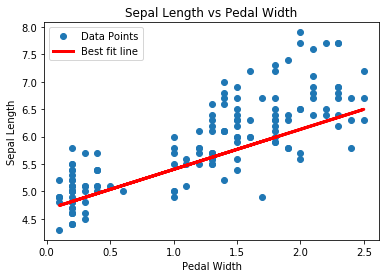

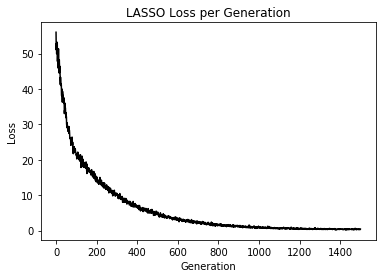

In [10]:
%matplotlib inline
# 画出结果
plt.plot(x_vals, y_vals, 'o', label='Data Points')
plt.plot(x_vals, best_fit, 'r-', label='Best fit line', linewidth=3)
plt.legend(loc='upper left')
plt.title('Sepal Length vs Pedal Width')
plt.xlabel('Pedal Width')
plt.ylabel('Sepal Length')
plt.show()

# 画出损失变化情况
plt.plot(loss_vec, 'k-')
plt.title(regression_type + ' Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()